In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
import cv2

In [2]:
# Load metadata
df = pd.read_csv("dataset/HAM10000_metadata.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
# Define both image folders
image_path1 = "dataset/HAM10000_images_part_1/"
image_path2 = "dataset/HAM10000_images_part_2/"

# Create image_id to path mapping from both folders
image_dict = {}

for folder in [image_path1, image_path2]:
    for img_name in os.listdir(folder):
        image_id = img_name.split('.')[0]
        image_dict[image_id] = os.path.join(folder, img_name)

In [4]:
df['path'] = df['image_id'].map(image_dict.get)

In [5]:
# Check the first few mapped paths
print(df[['image_id', 'path']].head())

# Check for missing images
missing = df['path'].isnull().sum()
print(f"Missing image paths: {missing}")

       image_id                                             path
0  ISIC_0027419  dataset/HAM10000_images_part_1/ISIC_0027419.jpg
1  ISIC_0025030  dataset/HAM10000_images_part_1/ISIC_0025030.jpg
2  ISIC_0026769  dataset/HAM10000_images_part_1/ISIC_0026769.jpg
3  ISIC_0025661  dataset/HAM10000_images_part_1/ISIC_0025661.jpg
4  ISIC_0031633  dataset/HAM10000_images_part_2/ISIC_0031633.jpg
Missing image paths: 0


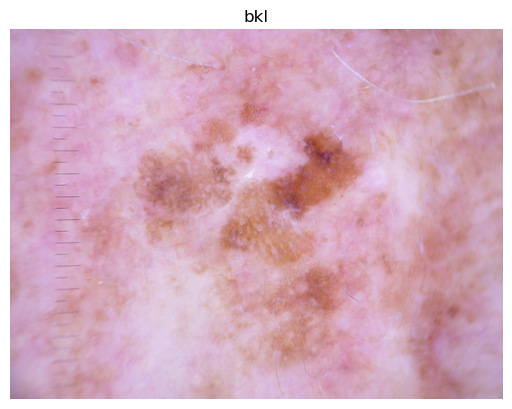

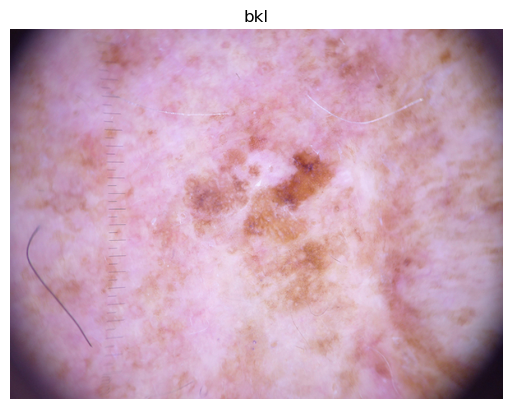

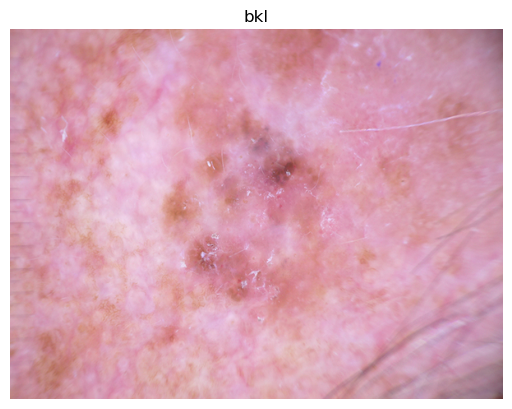

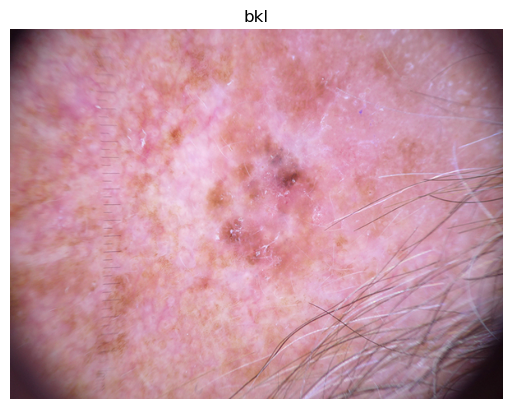

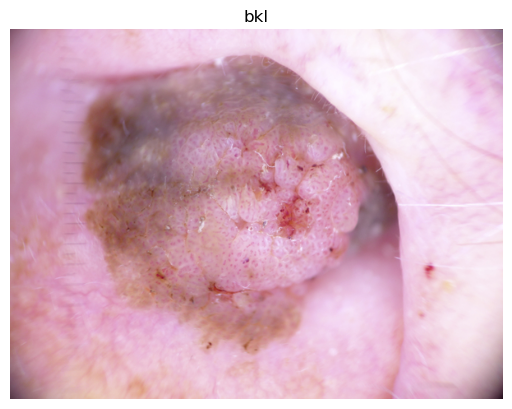

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display first 5 images
for i in range(5):
    img = mpimg.imread(df.iloc[i]['path'])
    plt.imshow(img)
    plt.title(df.iloc[i]['dx'])  # Display label
    plt.axis('off')
    plt.show()

In [7]:
df['dx'] = df['dx'].astype(str)  

In [8]:
label_dict = {label: idx for idx, label in enumerate(df['dx'].unique())}
df['label'] = df['dx'].map(label_dict)

In [9]:
print("Label Dictionary:")
print(label_dict)

Label Dictionary:
{'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}


In [10]:
from tensorflow.keras.utils import to_categorical

# Ensure labels are int and one-hot encoded
df['label'] = df['label'].astype(int)
labels = to_categorical(df['label'], num_classes=7)

In [11]:
print("Label Dictionary:")
print(label_dict)

Label Dictionary:
{'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}


In [12]:
from sklearn.model_selection import train_test_split

# First split: train (70%), temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['dx'], random_state=42)

# Second split: val (15%), test (15%) from the temp set
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['dx'], random_state=42)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 7010 | Val: 1502 | Test: 1503


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 256  # You can use 64 or 128 too depending on the model
BATCH_SIZE = 32

# Create generators
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)
val_gen = ImageDataGenerator(rescale=1./255)

# Flow from dataframe
train_generator = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # if using one-hot labels
)

val_generator = val_gen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_generator = val_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='dx',  # or 'dx' if consistent with other generators
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 7010 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.


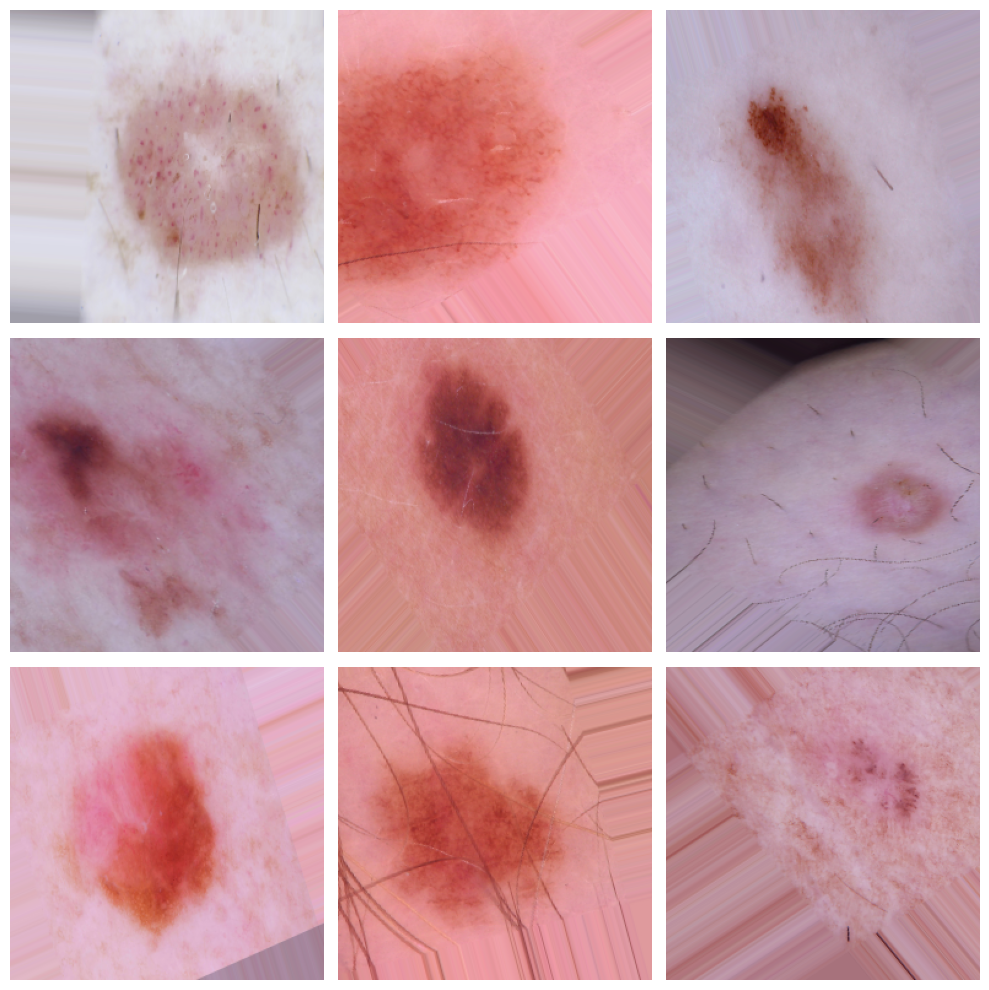

In [15]:
import matplotlib.pyplot as plt

# Preview augmented images
images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
# Load MobileNetV2 as base model
base_model = MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base layers for transfer learning

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(128,activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Check summary
model.summary()

C:\Users\DESKTOP\AppData\Local\Temp\ipykernel_16520\81225195.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 128, 128, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 128, 128, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 128, 128, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 128, 128, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 128, 128, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 128, 128, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 128, 128, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 128, 128, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 128, 128, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 128, 128, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 128, 128, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 129, 129, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 64, 64, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df['dx']),
    y=train_df['dx']
)

class_weights_dict = dict(zip(train_generator.class_indices.values(), class_weights))

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint('mobilenetv2_best3_model.keras', save_best_only=True)
]

In [19]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
     class_weight=class_weights_dict
)

C:\Users\DESKTOP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 533s 2s/step - accuracy: 0.2921 - loss: 1.9862 - val_accuracy: 0.4561 - val_loss: 1.5368
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 564s 2s/step - accuracy: 0.4122 - loss: 1.7123 - val_accuracy: 0.5126 - val_loss: 1.3783
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 525s 2s/step - accuracy: 0.4322 - loss: 1.4859 - val_accuracy: 0.3069 - val_loss: 1.6447
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 490s 2s/step - accuracy: 0.4134 - loss: 1.5657 - val_accuracy: 0.4714 - val_loss: 1.3368
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 490s 2s/step - accuracy: 0.4098 - loss: 1.4954 - val_accuracy: 0.3609 - val_loss: 1.4443
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 489s 2s/step - accuracy: 0.4060 - loss: 1.4282 - val_accuracy: 0.5153 - val_loss: 1.2001
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - accuracy: 0.4392 - loss: 1.4940 - val_accuracy: 0.5353 - val_loss: 1.2106
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 489s 2s/step - accuracy: 0.4398 - loss: 1.4037 - val_accu

In [20]:
from tensorflow.keras.models import load_model

In [21]:
model = load_model('mobilenetv2_bestl.keras')

C:\Users\DESKTOP\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 60 variables whereas the saved optimizer has 118 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [22]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

C:\Users\DESKTOP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8056 - loss: 0.6228
Test Accuracy: 0.7951
Test Loss: 0.6531


In [24]:
train_loss, train_acc = model.evaluate(train_generator)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Training Loss: {train_loss:.4f}")

220/220 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.8021 - loss: 0.6015
Training Accuracy: 0.8016
Training Loss: 0.5928


In [28]:
history = model.fit(...) 

ValueError: Unrecognized data type: x=Ellipsis (of type <class 'ellipsis'>)

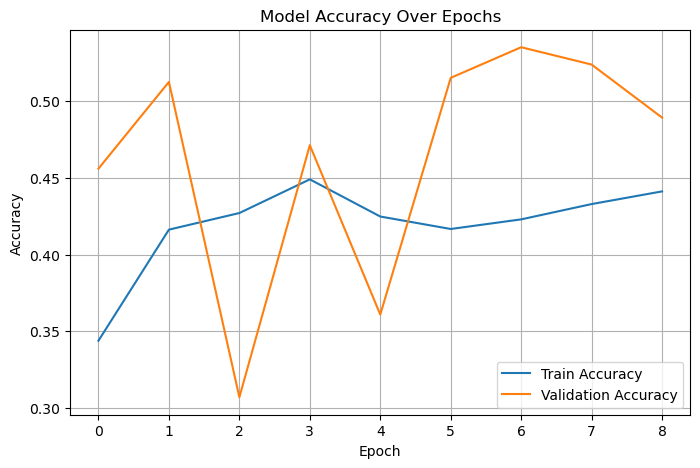

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

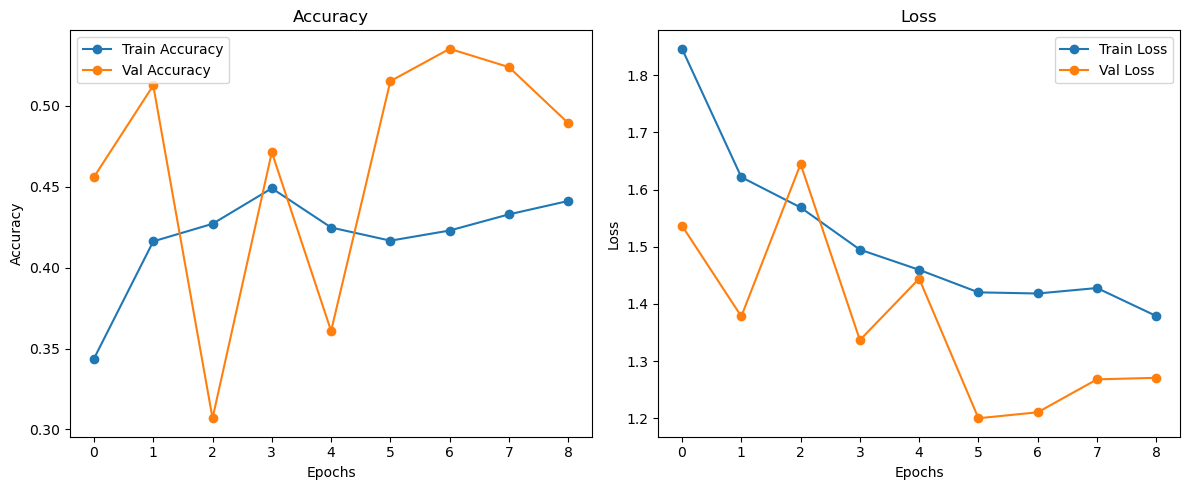

In [26]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
import matplotlib.pyplot as plt

# Accuracy bar plot
plt.figure(figsize=(6, 5))
sets = ['Train', 'Validation', 'Test']
accuracies = [train_acc, val_acc, test_acc]

plt.bar(sets, accuracies, color=['skyblue', 'orange', 'green'])
plt.title("Model Accuracy on Different Sets")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # accuracy range from 0 to 1
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)
plt.show()


NameError: name 'val_acc' is not defined

<Figure size 600x500 with 0 Axes>

In [30]:
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)


220/220 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.8058 - loss: 0.5906
47/47 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7866 - loss: 0.6231
47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8056 - loss: 0.6228


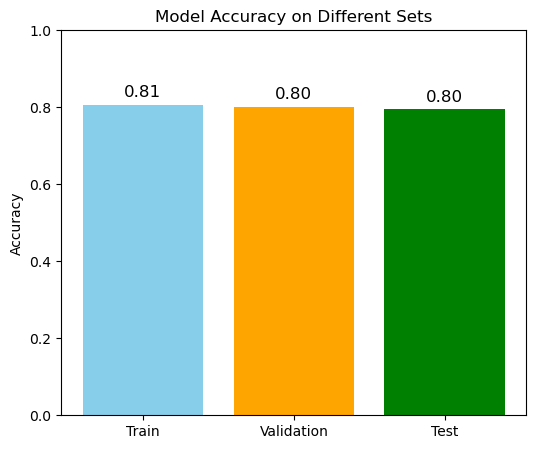

In [31]:
import matplotlib.pyplot as plt

# Accuracy bar plot
plt.figure(figsize=(6, 5))
sets = ['Train', 'Validation', 'Test']
accuracies = [train_acc, val_acc, test_acc]

plt.bar(sets, accuracies, color=['skyblue', 'orange', 'green'])
plt.title("Model Accuracy on Different Sets")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)
plt.show()

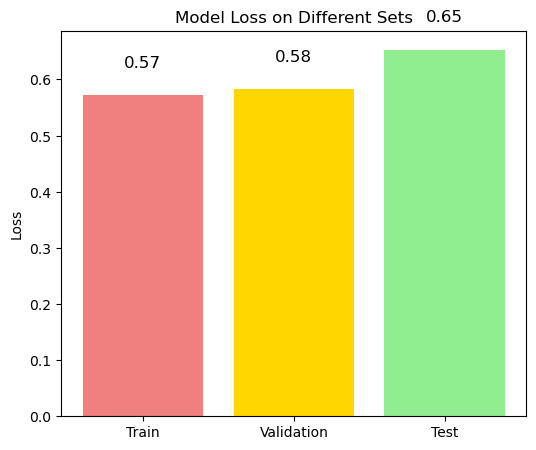

In [32]:
import matplotlib.pyplot as plt

# Loss bar plot
plt.figure(figsize=(6, 5))
sets = ['Train', 'Validation', 'Test']
losses = [train_loss, val_loss, test_loss]

plt.bar(sets, losses, color=['lightcoral', 'gold', 'lightgreen'])
plt.title("Model Loss on Different Sets")
plt.ylabel("Loss")
for i, loss in enumerate(losses):
    plt.text(i, loss + 0.05, f"{loss:.2f}", ha='center', fontsize=12)
plt.show()
